Author: Pascal, `pascal@bayesimpact.org`

Date: 2016-04-26

Skip the run test because the ROME version has to be updated to make it work in the exported repository. TODO: Update ROME and remove the `skiptest` flag.

    
# ROME mobility

The ROME dataset contains links between ROME job groups, it is called "mobilité" (mobility in French) as this is used to tell job seekers to which other jobs they could move.

This notebook does a sanity check on this table, before we use it in our product.

In [1]:
from os import path
import pandas
import seaborn as _
%matplotlib inline

rome_version = 'v330'
data_folder = '../../../data'
rome_folder = path.join(data_folder, 'rome/csv')
mobility_csv = path.join(rome_folder, 'unix_rubrique_mobilite_%s_utf8.csv' % rome_version)
rome_csv = path.join(rome_folder, 'unix_referentiel_code_rome_%s_utf8.csv' % rome_version)
appellation_csv = path.join(rome_folder, 'unix_referentiel_appellation_%s_utf8.csv' % rome_version)

mobility = pandas.read_csv(mobility_csv)
rome = pandas.read_csv(rome_csv)[['code_rome', 'libelle_rome']]
rome_names = rome.groupby('code_rome').first()['libelle_rome']
jobs = pandas.read_csv(appellation_csv)[['code_ogr', 'code_rome', 'libelle_appellation_court']]
jobs_names = jobs.groupby('code_ogr').first()['libelle_appellation_court']

## First Look
Let's first check how it looks like:

In [2]:
mobility.head(2).transpose()

,0,1
code_rome,A1101,A1202
code_rome_cible,A1416,A1203
code_appellation_source,NaN,NaN
code_appellation_cible,NaN,NaN
code_type_mobilite,1,1
libelle_type_mobilite,Proche,Proche


In [3]:
mobility.count()

code_rome                  4210
code_rome_cible            4210
code_appellation_source     223
code_appellation_cible      761
code_type_mobilite         4210
libelle_type_mobilite      4210
dtype: int64

In [4]:
mobility[mobility.code_appellation_source.notnull()].head(2).transpose()

,38,80
code_rome,A1413,B1303
code_rome_cible,D1501,B1603
code_appellation_source,17010,15405
code_appellation_cible,NaN,15415
code_type_mobilite,1,1
libelle_type_mobilite,Proche,Proche


It seems pretty straight forward: it's a list of links from a job group (or a specific job) to another (group or specific job). So let's clean up a bit and add names.

In [5]:
# Rename columns.
mobility.rename(columns={
        'code_rome': 'group_source',
        'code_appellation_source': 'job_source',
        'code_rome_cible': 'group_target',
        'code_appellation_cible': 'job_target',
    }, inplace=True)

# Add names.
mobility['group_source_name'] = mobility['group_source'].map(rome_names)
mobility['group_target_name'] = mobility['group_target'].map(rome_names)
mobility['job_source_name'] = mobility['job_source'].map(jobs_names)
mobility['job_target_name'] = mobility['job_target'].map(jobs_names)

# Sort columns.
mobility = mobility[[
        'group_source', 'group_source_name', 'job_source', 'job_source_name',
        'group_target', 'group_target_name', 'job_target', 'job_target_name',
        'code_type_mobilite', 'libelle_type_mobilite'
    ]]

mobility.head(2).transpose()

,0,1
group_source,A1101,A1202
group_source_name,Conduite d''engins agricoles et forestiers,Entretien des espaces naturels
job_source,NaN,NaN
job_source_name,NaN,NaN
group_target,A1416,A1203
group_target_name,"Polyculture, élevage",Entretien des espaces verts
job_target,NaN,NaN
job_target_name,NaN,NaN
code_type_mobilite,1,1
libelle_type_mobilite,Proche,Proche


## Sanity

Let's do some sanity checks:
- Is there links from a job group to itself?
- Is there duplicate links?
- If there is a link from A to B, is there one from B to A?
- When using specific jobs, is there also links from or to the job group?

In [6]:
# Links from one job group to the same one.
len(mobility[mobility.group_source == mobility.group_target].index)

0

In [7]:
# Number of duplicate links.
len(mobility.index) - len(mobility.drop_duplicates())

0

In [8]:
# Number of duplicate links when we ignore the link types.
len(mobility.index) - len(mobility.drop_duplicates([
    'group_source', 'job_source', 'group_target', 'job_target']))

0

In [9]:
# Reverse links.
two_links = pandas.merge(
    mobility.fillna(''), mobility.fillna(''),
    left_on=['group_target', 'job_target'],
    right_on=['group_source', 'job_source'])
str(len(two_links[
        (two_links.group_source_x == two_links.group_target_y) &
        (two_links.job_source_x == two_links.job_target_y)].index) / len(mobility.index) * 100) + '%'

'33.4916864608076%'

In [10]:
rome_froms = pandas.merge(
    mobility[mobility.job_source.notnull()].drop_duplicates(['group_source', 'group_source_name']),
    mobility[mobility.job_source.isnull()].drop_duplicates(['group_source', 'group_source_name']),
    on=['group_source', 'group_source_name'], how='outer', suffixes=['_specific', '_group'])

# Number of ROME job groups that have links both for the group and for at least one specific job.
len(rome_froms[rome_froms.group_target_specific.notnull() & rome_froms.group_target_group.notnull()])

79

In [11]:
# ROME job groups that have only links for specific jobs and not for the group.
rome_froms[rome_froms.group_target_group.isnull()]['group_source_name'].tolist()

['Collaboration juridique']

In [12]:
rome_froms = pandas.merge(
    mobility[mobility.job_source.notnull()].drop_duplicates(['group_target', 'group_target_name']),
    mobility[mobility.job_source.isnull()].drop_duplicates(['group_target', 'group_target_name']),
    on=['group_target', 'group_target_name'], how='outer', suffixes=['_specific', '_group'])

# Number of ROME job groups that have links both to the group and to at least one specific job.
len(rome_froms[rome_froms.group_source_specific.notnull() & rome_froms.group_source_group.notnull()])

88

In [13]:
# ROME job groups that have only links to specific jobs and not to the whole group.
rome_froms[rome_froms.group_source_group.isnull()]['group_target_name'].tolist()

['Image cinématographique et télévisuelle',
 'Personnel technique des jeux',
 'Pharmacie',
 'Santé animale',
 'Médecine dentaire',
 'Intervention technique en formulation et analyse sensorielle']

In [14]:
# Number of links specific to jobs (as opposed to groups) that are already specified by group links.
mobility['has_job_source'] = ~mobility.job_source.isnull()
mobility['has_job_target'] = ~mobility.job_target.isnull()
any_job_mobility = mobility.drop_duplicates(['group_source', 'has_job_source', 'group_target', 'has_job_target'])
len(any_job_mobility) - len(any_job_mobility.drop_duplicates(['group_source', 'group_target']))

0

So to summarize:
* There are **no self** links from a job group to itself, or within a group.
* There are **no duplicate** links (even with a different type).
* 33% of links go both way: so it means that **direction is meaningful**.
* When using specific jobs, in most cases there's also links concerning the whole job group; but for some rare cases it happens that there's nothing for the group.
* However when there's a link to or from a specific job, there's never an equivalent group link that would encompass it.

## Coverage

Let's check how much of the ROME code is covered by links, more specifically: for a given job, how many mobility jobs and job groups are linked from it (either directly or because of its group)?

In [15]:
# In this snippet, we count # of links to groups & to specific jobs for each job.

mobility_from_group = mobility[mobility.job_source.isnull()][['group_source', 'group_target', 'job_target']]
# Count # of groups that are linked from each group.
mobility_from_group['target_groups'] = (
    mobility_from_group[mobility_from_group.job_target.isnull()]
        .groupby('group_source')['group_source'].transform('count'))
mobility_from_group['target_groups'].fillna(0, inplace=True)
# Count # of specific jobs that are linked from each group.
mobility_from_group['target_jobs'] = (
    mobility_from_group[mobility_from_group.job_target.notnull()]
        .groupby('group_source')['group_source'].transform('count'))
mobility_from_group['target_jobs'].fillna(0, inplace=True)

mobility_from_group = mobility_from_group.groupby('group_source', as_index=False).max()[
    ['group_source', 'target_groups', 'target_jobs']]


mobility_from_job = mobility[mobility.job_source.notnull()][['job_source', 'group_target', 'job_target']]
# Count # of groups that are linked from each job.
mobility_from_job['target_groups'] = (
    mobility_from_job[mobility_from_job.job_target.isnull()]
        .groupby('job_source')['job_source'].transform('count'))
mobility_from_job['target_groups'].fillna(0, inplace=True)
# Count # of jobs that are linked from each job.
mobility_from_job['target_jobs'] = (
    mobility_from_job[mobility_from_job.job_target.notnull()]
        .groupby('job_source')['job_source'].transform('count'))
mobility_from_job['target_jobs'].fillna(0, inplace=True)

mobility_from_job = mobility_from_job.groupby('job_source', as_index=False).max()[
    ['job_source', 'target_groups', 'target_jobs']]

jobs_with_counts = pandas.merge(
    jobs, mobility_from_group, left_on='code_rome', right_on='group_source', how='left')
jobs_with_counts = pandas.merge(
    jobs_with_counts, mobility_from_job, left_on='code_ogr', right_on='job_source', how='left')

jobs_with_counts.fillna(0, inplace=True)
jobs_with_counts['target_groups'] = jobs_with_counts.target_groups_x + jobs_with_counts.target_groups_y
jobs_with_counts['target_jobs'] = jobs_with_counts.target_jobs_x + jobs_with_counts.target_jobs_y
jobs_with_counts['total'] = jobs_with_counts['target_groups'] + jobs_with_counts['target_jobs']

jobs_with_counts = jobs_with_counts[['code_ogr', 'libelle_appellation_court', 'target_groups', 'target_jobs', 'total']]

In [16]:
# Jobs that don't have any links from them or from their group.
jobs_with_counts[jobs_with_counts.total == 0]['libelle_appellation_court'].tolist()

['Assistant / Assistante de service juridique',
 'Assistant notarial / Assistante notariale',
 'Auxiliaire juridique',
 'Clerc',
 'Clerc assermenté',
 'Clerc aux formalités',
 'Clerc aux formalités de notaire',
 "Clerc d''avocat",
 'Clerc de commissaire-priseur',
 "Clerc d''huissier",
 'Clerc formaliste',
 'Clerc hors rang',
 'Clerc hors rang de notaire',
 'Clerc rédacteur',
 'Clerc significateur',
 "Clerc significateur assermenté d''huissier",
 "Collaborateur(trice) d''huissier chargé(e) de recouvrement",
 'Greffier / Greffière',
 'Greffier / Greffière en chef',
 'Premier clerc',
 'Principal clerc',
 'Principal clerc adjoint',
 'Principal clerc adjoint de notaire',
 "Principal clerc d''avocat",
 'Principal clerc de commissaire-priseur',
 'Principal clerc de notaire',
 "Principal clerc d''huissier",
 "Sous-principal clerc d''avocat",
 'Sous-principal clerc de notaire',
 'Formaliste']

'85.4585312385824%'

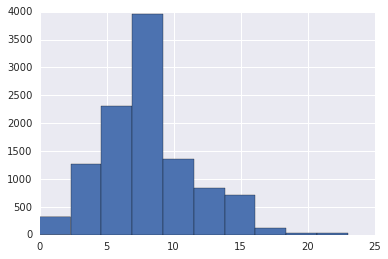

In [17]:
jobs_with_counts.total.hist()
str(len(jobs_with_counts.total[jobs_with_counts.total >= 5].index) / len(jobs_with_counts.index)*100) + '%'

For each job, except for the ~30 jobs above in the law business, there is at least one link, and in most of the cases (85%) there are 5 or more.